In [1]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
import pickle

In [2]:
path = '/home/pradeep/Speed limit datasets'
testRatio = 0.2
valRatio = 0.2
imageDimensions= (60,60,3)
batchSizeVal= 50
epochsVal = 10


In [3]:
count = 0
images = []     # LIST CONTAINING ALL THE IMAGES
classNo = []    # LIST CONTAINING ALL THE CORRESPONDING CLASS ID OF IMAGES
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses = len(myList)

Total Classes Detected: 9


In [4]:
count = 0
images = []     # LIST CONTAINING ALL THE IMAGES
classNo = []    # LIST CONTAINING ALL THE CORRESPONDING CLASS ID OF IMAGES
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses = len(myList)
# print(myList)
print("Importing Classes .......")
for x in range(0,9):
    myPicList = os.listdir(path+"/"+str(x))
#     print(myPicList)
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(x)+"/"+y)
        curImg = cv2.resize(curImg,(60,60))
        images.append(curImg)
        classNo.append(x)
    print(x,end= " ")
print(" ")
print("Total Images in Images List = ",len(images))
print("Total IDS in classNo List= ",len(classNo))

Total Classes Detected: 9
Importing Classes .......
0 1 2 3 4 5 6 7 8  
Total Images in Images List =  3142
Total IDS in classNo List=  3142


In [5]:
images = np.array(images)
classNo = np.array(classNo)
print(images.shape)

# SPLITTING THE DATA
X_train,X_test,y_train,y_test = train_test_split(images,classNo,test_size=testRatio)
X_train,X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size=valRatio)
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(3142, 60, 60, 3)
(2010, 60, 60, 3)
(629, 60, 60, 3)
(503, 60, 60, 3)


[144, 206, 204, 199, 213, 265, 274, 202, 303]


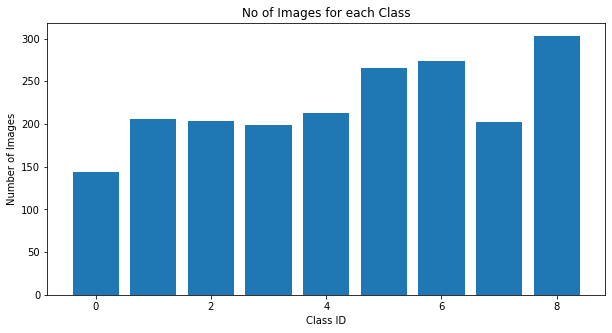

In [6]:
numOfSamples= []
for x in range(0,noOfClasses):
    #print(len(np.where(y_train==x)[0]))
    numOfSamples.append(len(np.where(y_train==x)[0]))
print(numOfSamples)

plt.figure(figsize=(10,5))
plt.bar(range(0,noOfClasses),numOfSamples)
plt.title("No of Images for each Class")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()

In [7]:

def preProcessing(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img

X_train= np.array(list(map(preProcessing,X_train)))
X_test= np.array(list(map(preProcessing,X_test)))
X_validation= np.array(list(map(preProcessing,X_validation)))

In [8]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
X_validation = X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)

In [9]:
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(X_train)


In [10]:
y_train = to_categorical(y_train,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)

In [11]:
def myModel():
    noOfFilters = 60
    sizeOfFilter1 = (5,5)
    sizeOfFilter2 = (3, 3)
    sizeOfPool = (2,2)
    noOfNodes= 500

    model = Sequential()
    model.add((Conv2D(noOfFilters,sizeOfFilter1,input_shape=(imageDimensions[0],
                      imageDimensions[1],1),activation='relu')))
    model.add((Conv2D(noOfFilters, sizeOfFilter1, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(noOfNodes,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))

    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

model = myModel()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 52, 52, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 30)        8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 30)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 30)        0

/home/pradeep/.local/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
history = model.fit_generator(dataGen.flow(X_train,y_train,
                                 batch_size=batchSizeVal),
                                 epochs=epochsVal,
                                 validation_data=(X_validation,y_validation),
                                 shuffle=1)

/home/pradeep/.local/lib/python3.6/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
41/41 [==============================] - 48s 1s/step - loss: 2.0677 - accuracy: 0.2418 - val_loss: 1.4584 - val_accuracy: 0.5427
Epoch 2/10
41/41 [==============================] - 46s 1s/step - loss: 1.5422 - accuracy: 0.4682 - val_loss: 0.9340 - val_accuracy: 0.7356
Epoch 3/10
41/41 [==============================] - 51s 1s/step - loss: 1.1714 - accuracy: 0.5910 - val_loss: 0.6000 - val_accuracy: 0.7873
Epoch 4/10
41/41 [==============================] - 50s 1s/step - loss: 0.9744 - accuracy: 0.6637 - val_loss: 0.5876 - val_accuracy: 0.8231
Epoch 5/10
41/41 [==============================] - 50s 1s/step - loss: 0.8409 - accuracy: 0.7060 - val_loss: 0.4556 - val_accuracy: 0.8350
Epoch 6/10
41/41 [==============================] - 50s 1s/step - loss: 0.7425 - accuracy: 0.7274 - val_loss: 0.3454 - val_accuracy: 0.9085
Epoch 7/10
41/41 [==============================] - 50s 1s/step - loss: 0.6837 - accuracy: 0.7448 - val_loss: 0.3139 - val_accuracy: 0.9245
Epoch 8/10
41/41 [==

In [13]:
model.metrics_names
model.evaluate(X_test,y_test)
model.save('model.h5')
print("Saving the model as model.h5")

20/20 [==============================] - 3s 161ms/step - loss: 0.1817 - accuracy: 0.9634
Saving the model as model.h5


Sign is predicted as 80 km/h


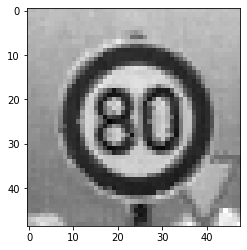

In [16]:

img = cv2.imread('/home/pradeep/Music/2.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap ='gray')

img = cv2.equalizeHist(img)
img = img/255
img = cv2.resize(img,(60,60))

img = img.reshape(1,60,60,1)
predict_x=model.predict(img) 
classIndex=np.argmax(predict_x,axis=1)

if classIndex == 0:
    print('Sign is predicted as 20 km/h')
if classIndex == 1:
    print('Sign is predicted as 30 km/h')
if classIndex == 2:
    print('Sign is predicted as 50 km/h')
if classIndex == 3:
    print('Sign is predicted as 80 km/h')
if classIndex == 4:
    print('Sign is predicted as 100 km/h')
if classIndex == 5:
    print('Sign is predicted as NO HORN')
if classIndex == 6:
    print('Sign is predicted as GO STRAIGHT')
if classIndex == 7:
    print('Sign is predicted as TURN LEFT')
if classIndex == 8:
    print('Sign is predicted as TURN RIGHT')
    
